In [ ]:
pip install meteostat

# Data Preprocessing and Feature Engineering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV


## Getting consumption Dataframe


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/MyDrive/ML Collab/Consumption/household_power_consumption.csv"
dtypes = {
  'Date': str,
  'Time': str,
  'Global_active_power': float,
  'Global_reactive_power': float,
  'Voltage': float,
  'Global_intensity': float,
  'Sub_metering_1': float,
  'Sub_metering_2': float,
  'Sub_metering_3': float
}

try:
  df_cons = pd.read_csv(file_path, sep=';', dtype=dtypes, na_values=['nan','?'])
except FileNotFoundError:
  print(f"Error: File not found at {file_path}. Please check the file path.")
  df_cons = None

df_cons['Datetime'] = pd.to_datetime(df_cons['Date'] , format='%d/%m/%Y')

df_cons.drop(columns=['Date', 'Time'], inplace=True)

df_cons.dropna(inplace=True)

df_cons['Energy_kWh'] = df_cons['Global_active_power'] * (1 / 60)

daily_energy = df_cons.groupby(df_cons['Datetime'].dt.date)['Energy_kWh'].sum()

df_daily_energy = pd.DataFrame({'Date': daily_energy.index, 'Daily_Energy_kWh': daily_energy.values})

df_daily_energy['Date'] = pd.to_datetime(df_daily_energy['Date'], format='%d/%m/%Y')

df_daily_energy

,Date,Daily_Energy_kWh
0,2006-12-16,20.152933
1,2006-12-17,56.507667
2,2006-12-18,36.730433
3,2006-12-19,27.769900
4,2006-12-20,37.095800
...,...,...
1428,2010-11-22,34.025600
1429,2010-11-23,26.292267
1430,2010-11-24,29.937467
1431,2010-11-25,23.852733


In [ ]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Hourly, Point
from meteostat import Stations, Daily

# Set time period
start = datetime(2006,12,16, 17,27,00)
end = datetime(2010, 12, 31, 23, 59)
sceaux= Point(48.7943, 2.2715)

# Get hourly data
df_weather = Daily(sceaux, start, end)
df_weather = df_weather.fetch()
df_weather['time'] = df_weather.index
df_weather['time'] = pd.to_datetime(df_weather['time'])
df_weather.info()
df_weather

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1476 entries, 2006-12-17 to 2010-12-31
Freq: D
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   tavg    1476 non-null   float64       
 1   tmin    1476 non-null   float64       
 2   tmax    1476 non-null   float64       
 3   prcp    1476 non-null   float64       
 4   snow    45 non-null     float64       
 5   wdir    1445 non-null   float64       
 6   wspd    1459 non-null   float64       
 7   wpgt    0 non-null      float64       
 8   pres    1425 non-null   float64       
 9   tsun    0 non-null      float64       
 10  time    1476 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 138.4 KB


,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,time
time,,,,,,,,,,,
2006-12-17,4.4,1.1,7.9,3.3,NaN,217.0,4.6,NaN,1029.5,NaN,2006-12-17
2006-12-18,4.6,3.4,6.0,0.0,NaN,125.0,6.5,NaN,1029.0,NaN,2006-12-18
2006-12-19,2.6,0.5,5.2,0.0,NaN,22.0,14.8,NaN,1034.1,NaN,2006-12-19
2006-12-20,2.9,0.5,5.7,0.0,NaN,21.0,13.5,NaN,1037.5,NaN,2006-12-20
2006-12-21,5.2,1.7,8.5,0.0,NaN,23.0,14.5,NaN,1039.4,NaN,2006-12-21
...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,-0.8,-2.3,0.6,0.0,10.0,139.0,10.1,NaN,1022.5,NaN,2010-12-27
2010-12-28,1.2,-1.4,2.8,2.2,NaN,163.0,7.5,NaN,1018.2,NaN,2010-12-28
2010-12-29,4.5,2.5,7.0,0.0,NaN,111.0,4.4,NaN,1021.0,NaN,2010-12-29


In [ ]:
df_weather['Year'] = df_weather['time'].dt.year
df_weather['Month'] = df_weather['time'].dt.month
df_weather['Day'] = df_weather['time'].dt.day
df_weather['Day_of_week'] = df_weather['time'].dt.dayofweek #0 being monday and 6 being sunday
df_weather.drop(columns=['time'], inplace=True)
df_weather.isnull().sum()
df_weather

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,Year,Month,Day,Day_of_week
time,,,,,,,,,,,,,,
2006-12-17,4.4,1.1,7.9,3.3,NaN,217.0,4.6,NaN,1029.5,NaN,2006,12,17,6
2006-12-18,4.6,3.4,6.0,0.0,NaN,125.0,6.5,NaN,1029.0,NaN,2006,12,18,0
2006-12-19,2.6,0.5,5.2,0.0,NaN,22.0,14.8,NaN,1034.1,NaN,2006,12,19,1
2006-12-20,2.9,0.5,5.7,0.0,NaN,21.0,13.5,NaN,1037.5,NaN,2006,12,20,2
2006-12-21,5.2,1.7,8.5,0.0,NaN,23.0,14.5,NaN,1039.4,NaN,2006,12,21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,-0.8,-2.3,0.6,0.0,10.0,139.0,10.1,NaN,1022.5,NaN,2010,12,27,0
2010-12-28,1.2,-1.4,2.8,2.2,NaN,163.0,7.5,NaN,1018.2,NaN,2010,12,28,1
2010-12-29,4.5,2.5,7.0,0.0,NaN,111.0,4.4,NaN,1021.0,NaN,2010,12,29,2


In [ ]:
# prompt: Merge df_daily_energy and df_weather based on the days

import pandas as pd
df_merged = pd.merge(df_daily_energy, df_weather, left_on='Date', right_on='time')
df_merged


,Date,Daily_Energy_kWh,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,Year,Month,Day,Day_of_week
0,2006-12-17,56.507667,4.4,1.1,7.9,3.3,NaN,217.0,4.6,NaN,1029.5,NaN,2006,12,17,6
1,2006-12-18,36.730433,4.6,3.4,6.0,0.0,NaN,125.0,6.5,NaN,1029.0,NaN,2006,12,18,0
2,2006-12-19,27.769900,2.6,0.5,5.2,0.0,NaN,22.0,14.8,NaN,1034.1,NaN,2006,12,19,1
3,2006-12-20,37.095800,2.9,0.5,5.7,0.0,NaN,21.0,13.5,NaN,1037.5,NaN,2006,12,20,2
4,2006-12-21,28.610400,5.2,1.7,8.5,0.0,NaN,23.0,14.5,NaN,1039.4,NaN,2006,12,21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,2010-11-22,34.025600,4.9,4.6,5.4,0.8,NaN,360.0,13.0,NaN,1005.8,NaN,2010,11,22,0
1428,2010-11-23,26.292267,5.3,3.1,7.0,0.0,NaN,297.0,8.6,NaN,1010.1,NaN,2010,11,23,1
1429,2010-11-24,29.937467,5.8,4.1,8.2,0.3,NaN,276.0,12.2,NaN,1011.0,NaN,2010,11,24,2
1430,2010-11-25,23.852733,3.7,1.4,6.4,0.0,NaN,307.0,8.0,NaN,1006.2,NaN,2010,11,25,3


In [ ]:
df_merged.dropna(subset=['Daily_Energy_kWh'], inplace=True)
df_merged.isnull().sum()

,0
Date,0
Daily_Energy_kWh,0
tavg,0
tmin,0
tmax,0
prcp,0
snow,1404
wdir,31
wspd,17
wpgt,1432


In [ ]:
df_merged.drop(columns=['snow','wpgt', 'tsun'], inplace=True)
df_merged.dropna(inplace=True)
df_merged.isna().sum()

,0
Date,0
Daily_Energy_kWh,0
tavg,0
tmin,0
tmax,0
prcp,0
wdir,0
wspd,0
pres,0
Year,0


In [ ]:
from scipy.stats import zscore

numerical_cols = df_merged.select_dtypes(include=np.number).columns
# Calculate z-scores for all columns
z_scores = np.abs(zscore(df_merged[numerical_cols]))

# Define a threshold for outlier detection (e.g., z-score > 3)
threshold = 3

# Identify outliers
outliers = np.where(z_scores > threshold)

# Remove rows with outliers
df_merged = df_merged[(z_scores < 3).all(axis=1)]

df_merged.describe()

,Date,Daily_Energy_kWh,tavg,tmin,tmax,prcp,wdir,wspd,pres,Year,Month,Day,Day_of_week
count,1314,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,2008-12-08 20:40:32.876712448,25.800099,12.432725,8.950228,16.607306,1.177321,186.764079,10.940563,1016.569406,2008.445205,6.447489,15.763318,2.992390
min,2006-12-18 00:00:00,0.236967,-4.700000,-7.600000,-1.600000,0.000000,0.000000,2.600000,988.200000,2006.000000,1.000000,1.000000,0.000000
25%,2007-12-24 06:00:00,19.444358,7.700000,4.825000,11.000000,0.000000,108.250000,8.200000,1011.400000,2007.000000,4.000000,8.000000,1.000000
50%,2008-12-12 12:00:00,25.579633,12.700000,9.200000,17.000000,0.000000,202.500000,10.350000,1016.900000,2008.000000,6.000000,16.000000,3.000000
75%,2009-11-22 18:00:00,31.421192,17.800000,13.700000,22.600000,1.000000,261.000000,13.200000,1022.300000,2009.000000,9.000000,23.000000,5.000000
max,2010-11-26 00:00:00,56.157967,27.500000,22.600000,35.600000,13.700000,360.000000,22.500000,1041.400000,2010.000000,12.000000,31.000000,6.000000
std,NaN,9.546825,6.490038,5.774471,7.623774,2.385381,102.137964,3.651995,9.136649,1.111648,3.413034,8.771943,1.983927


In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1314 entries, 1 to 1431
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1314 non-null   datetime64[ns]
 1   Daily_Energy_kWh  1314 non-null   float64       
 2   tavg              1314 non-null   float64       
 3   tmin              1314 non-null   float64       
 4   tmax              1314 non-null   float64       
 5   prcp              1314 non-null   float64       
 6   wdir              1314 non-null   float64       
 7   wspd              1314 non-null   float64       
 8   pres              1314 non-null   float64       
 9   Year              1314 non-null   int32         
 10  Month             1314 non-null   int32         
 11  Day               1314 non-null   int32         
 12  Day_of_week       1314 non-null   int32         
dtypes: datetime64[ns](1), float64(8), int32(4)
memory usage: 123.2 KB


In [ ]:
df_merged.isna().sum()

,0
Date,0
Daily_Energy_kWh,0
tavg,0
tmin,0
tmax,0
prcp,0
wdir,0
wspd,0
pres,0
Year,0


In [ ]:
from google.colab import data_table

df_merged['previousDay'] = df_merged['Daily_Energy_kWh'].shift(1)
df_merged['previous2Day'] = df_merged['Daily_Energy_kWh'].shift(2)
df_merged['previous3Day'] = df_merged['Daily_Energy_kWh'].shift(3)
df_merged['previous4Day'] = df_merged['Daily_Energy_kWh'].shift(4)
df_merged['previous5Day'] = df_merged['Daily_Energy_kWh'].shift(5)
df_merged['previous6Day'] = df_merged['Daily_Energy_kWh'].shift(6)
df_merged['previous7Day'] = df_merged['Daily_Energy_kWh'].shift(7)
# df_both.dropna(inplace=True)
df_merged.info()
df_merged

data_table.DataTable(df_merged)

<class 'pandas.core.frame.DataFrame'>
Index: 1314 entries, 1 to 1431
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1314 non-null   datetime64[ns]
 1   Daily_Energy_kWh  1314 non-null   float64       
 2   tavg              1314 non-null   float64       
 3   tmin              1314 non-null   float64       
 4   tmax              1314 non-null   float64       
 5   prcp              1314 non-null   float64       
 6   wdir              1314 non-null   float64       
 7   wspd              1314 non-null   float64       
 8   pres              1314 non-null   float64       
 9   Year              1314 non-null   int32         
 10  Month             1314 non-null   int32         
 11  Day               1314 non-null   int32         
 12  Day_of_week       1314 non-null   int32         
 13  previousDay       1313 non-null   float64       
 14  previous2Day      1312 non-nu

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,Date,Daily_Energy_kWh,tavg,tmin,tmax,prcp,wdir,wspd,pres,Year,Month,Day,Day_of_week,previousDay,previous2Day,previous3Day,previous4Day,previous5Day,previous6Day,previous7Day
1,2006-12-18,36.730433,4.6,3.4,6.0,0.0,125.0,6.5,1029.0,2006,12,18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-12-19,27.769900,2.6,0.5,5.2,0.0,22.0,14.8,1034.1,2006,12,19,1,36.730433,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-12-20,37.095800,2.9,0.5,5.7,0.0,21.0,13.5,1037.5,2006,12,20,2,27.769900,36.730433,NaN,NaN,NaN,NaN,NaN
4,2006-12-21,28.610400,5.2,1.7,8.5,0.0,23.0,14.5,1039.4,2006,12,21,3,37.095800,27.769900,36.730433,NaN,NaN,NaN,NaN
5,2006-12-22,39.022300,5.1,3.8,6.8,0.0,30.0,15.0,1039.5,2006,12,22,4,28.610400,37.095800,27.769900,36.730433,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,2010-11-22,34.025600,4.9,4.6,5.4,0.8,360.0,13.0,1005.8,2010,11,22,0,15.015167,36.616767,26.173333,27.535867,26.367200,25.162467,33.973200
1428,2010-11-23,26.292267,5.3,3.1,7.0,0.0,297.0,8.6,1010.1,2010,11,23,1,34.025600,15.015167,36.616767,26.173333,27.535867,26.367200,25.162467
1429,2010-11-24,29.937467,5.8,4.1,8.2,0.3,276.0,12.2,1011.0,2010,11,24,2,26.292267,34.025600,15.015167,36.616767,26.173333,27.535867,26.367200
1430,2010-11-25,23.852733,3.7,1.4,6.4,0.0,307.0,8.0,1006.2,2010,11,25,3,29.937467,26.292267,34.025600,15.015167,36.616767,26.173333,27.535867


In [ ]:
df_merged.head()

,Date,Daily_Energy_kWh,tavg,tmin,tmax,prcp,wdir,wspd,pres,Year,Month,Day,Day_of_week,previousDay,previous2Day,previous3Day,previous4Day,previous5Day,previous6Day,previous7Day
1,2006-12-18,36.730433,4.6,3.4,6.0,0.0,125.0,6.5,1029.0,2006,12,18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-12-19,27.769900,2.6,0.5,5.2,0.0,22.0,14.8,1034.1,2006,12,19,1,36.730433,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-12-20,37.095800,2.9,0.5,5.7,0.0,21.0,13.5,1037.5,2006,12,20,2,27.769900,36.730433,NaN,NaN,NaN,NaN,NaN
4,2006-12-21,28.610400,5.2,1.7,8.5,0.0,23.0,14.5,1039.4,2006,12,21,3,37.095800,27.769900,36.730433,NaN,NaN,NaN,NaN
5,2006-12-22,39.022300,5.1,3.8,6.8,0.0,30.0,15.0,1039.5,2006,12,22,4,28.610400,37.095800,27.769900,36.730433,NaN,NaN,NaN


In [ ]:
needs_scaling = [ 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd',
       'pres', 'previousDay', 'previous2Day',
       'previous3Day','previous4Day','previous5Day','previous6Day','previous7Day']

scaler = MinMaxScaler()
df_merged[needs_scaling] = scaler.fit_transform(df_merged[needs_scaling])
df_merged.head()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Daily_Energy_kWh,tavg,tmin,tmax,prcp,wdir,wspd,pres,Year,Month,Day,Day_of_week,previousDay,previous2Day,previous3Day,previous4Day,previous5Day,previous6Day,previous7Day
1,2006-12-18,36.730433,0.288820,0.364238,0.204301,0.0,0.347222,0.195980,0.766917,2006,12,18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-12-19,27.769900,0.226708,0.268212,0.182796,0.0,0.061111,0.613065,0.862782,2006,12,19,1,0.652590,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-12-20,37.095800,0.236025,0.268212,0.196237,0.0,0.058333,0.547739,0.926692,2006,12,20,2,0.492354,0.652590,NaN,NaN,NaN,NaN,NaN
4,2006-12-21,28.610400,0.307453,0.307947,0.271505,0.0,0.063889,0.597990,0.962406,2006,12,21,3,0.659123,0.492354,0.652590,NaN,NaN,NaN,NaN
5,2006-12-22,39.022300,0.304348,0.377483,0.225806,0.0,0.083333,0.623116,0.964286,2006,12,22,4,0.507384,0.659123,0.492354,0.65259,NaN,NaN,NaN


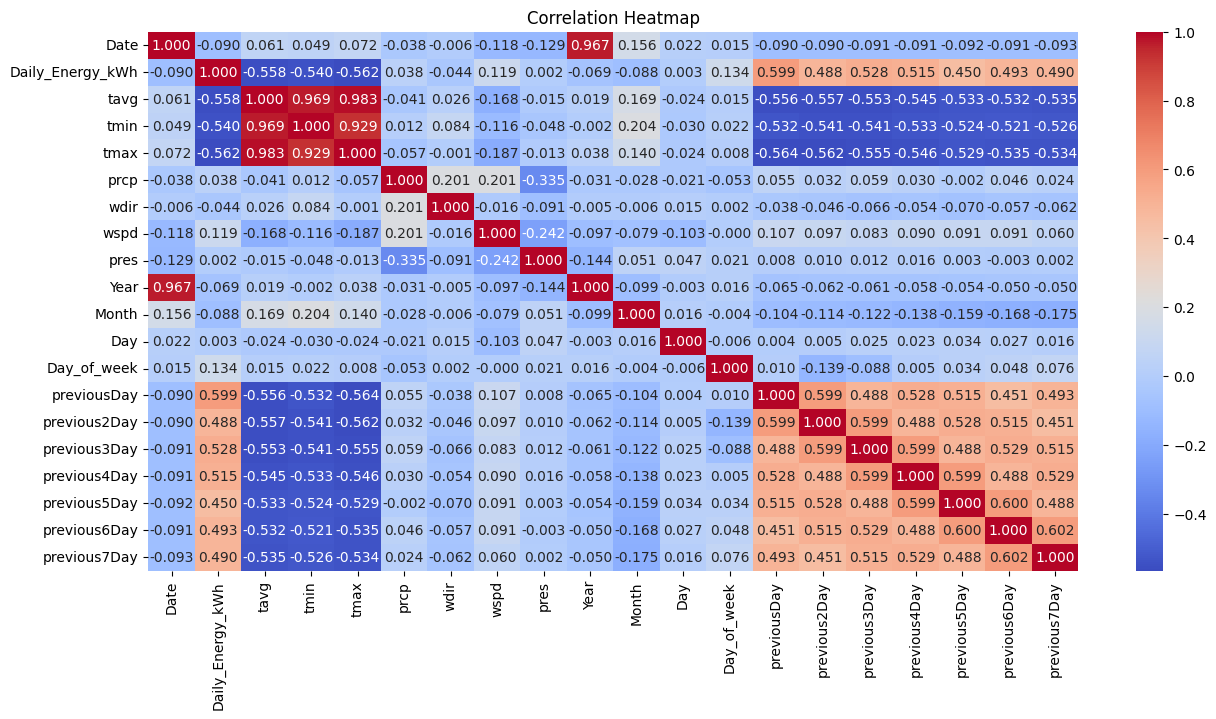

In [ ]:
corr_mat=df_merged.corr()
plt.figure(figsize=(15,7))
sns.heatmap(corr_mat, annot=True, fmt=".3f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
###########################################
# Saving the scaler and processed dataset #
###########################################

import os
import joblib

drive_save_dir = '/content/drive/MyDrive/ML Collab/'

os.makedirs(drive_save_dir, exist_ok=True)

# Save the scaler
scaler_path = os.path.join(drive_save_dir, 'long_term_scaler.pkl')
joblib.dump(scaler, scaler_path)

# Save the DataFrame
df_both_path = os.path.join(drive_save_dir, 'long_term_consumption.csv')
df_merged.to_csv(df_both_path)

print(f"Scaler saved to: {scaler_path}")
print(f"DataFrame saved to: {df_both_path}")



Scaler saved to: /content/drive/MyDrive/ML Collab/long_term_scaler.pkl
DataFrame saved to: /content/drive/MyDrive/ML Collab/long_term_consumption.csv
